# Adaptive Noise Cancellation
Doctor, in trying to review the electroencephalogram (EEG) of a distracted graduate student, finds that the signal he would like to see has been contaminated by a 60-Hz noise source. He is examining the patient on-line and wants to view the best signal that can be obtained.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from keras import models
from keras import layers
from keras import optimizers

2023-05-10 13:11:44.227695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:11:44.272112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:11:44.272696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 13:11:45.083509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



# Obtain the pure EEG Signal $S(k)$ from the data file *Data_EEG.txt* 

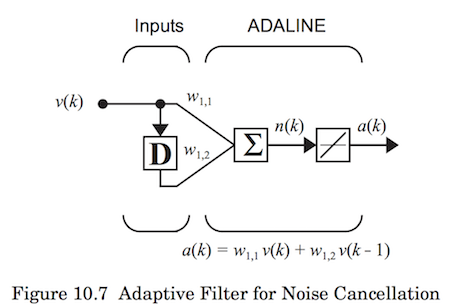

In [2]:
# Architecture of ADALINE of order 1:

from IPython.display import Image
Image("Adaline_Adaptive_Filter.png")

In [3]:
S= np.loadtxt('Data_EEG.txt',skiprows=1,unpack=True)
S_sqr=np.square(S)
Mean_S_sqr=np.mean(S_sqr)
n=len(S)

# Create the unfiltered signal $t(k)=S(k)+m(k)$ 
- $S(k)$: is the **pure EEG signal**
- $v(k)$: is the sampled sinusoidal electrical network signal (three times in a period) and considered as the input signal to ADALINE network and its output
- $m(k)$:  is the noisy signal comming from the electrical network. 
- $t(k)$: is the unfiltered signal (t(k)=S(k)+m(k))
- $a(k)$: is the estimation of the noisy signal m(k). 
- plot the pure signal $S(k)$ and unfiltered signal $T(k)$ in order to evaluate the filtering operated by ADALINE network.

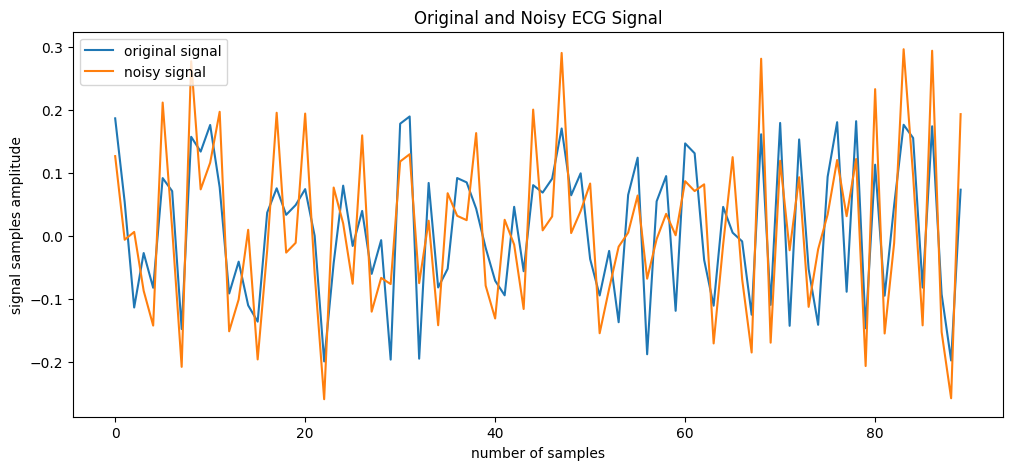

In [4]:
v=[]
m=[]
for i in range(30):
     v=np.concatenate((v,[1.2*np.sin(2*np.pi*(1/3)), 1.2*np.sin(2*np.pi*(2/3)), 1.2*np.sin(2*np.pi*(3/3))]))
     m=np.concatenate((m,[0.12*np.sin((2*np.pi*(1/3))+np.pi/2), 0.12*np.sin((2*np.pi*(2/3))+np.pi/2), 0.12*np.sin((2*np.pi*(3/3))+np.pi/2)]))

# Contaminated output signal    
t=S+m
#..........................
plt.figure(1,figsize=(12,5))
plt.plot(S)
plt.plot(t)
plt.legend(('original signal','noisy signal'),loc='upper left')
plt.title('Original and Noisy ECG Signal')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Filter Order Selection
ADALINE output $a(t)$ may be calculated based on:
- a first order model given in the figure using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ 
- a second order model given by  the mathematical expression:  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$

where the order is the number of retarded inputs signals used as input to neural network.

# First Order Filter Design:  Optimal Solution
- The optimal solution is obtained by minimizing **least mean square** (LMS) between 
the unfiltered signal T(k) and the output of the second order filter given 
by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. For more details please **see course slide nr.19**.
- $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$
- Let us note: $x=[w_1, b]^T$ and $ z=[v,1]^T \Rightarrow a=x^Tz $ is the ADALINE output
- Solution:  $w=R^{-1}h$ where  $h=E[tz]$ and   $R=E[zz^T]$ 
- In our calculation we have considered that the biais value $b=0$

 



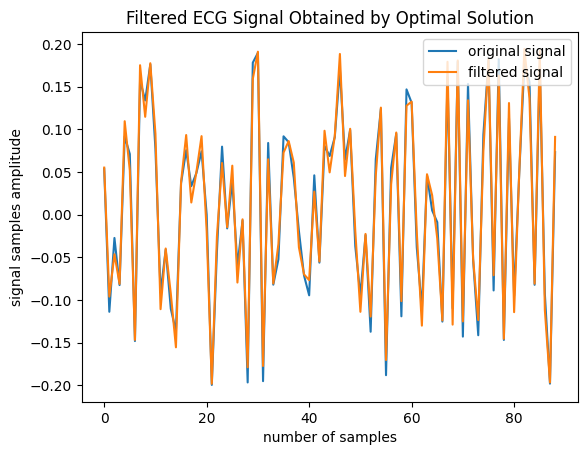

In [5]:
case="1ordre"
if case=='1ordre': # case of third order filter calculation
    n=len(t)-1
    w=np.array([0 , 0]) # initial values of synaptic weights
    b=0                 # initial values of baised value
    a=np.zeros(len(t)-1); # initial value of ADALINE network output
    V=np.array([v[1:90], v[0:89]]) #input signal
    T=t[1:90] # target signal 
    

 # Minimizing the square of difference between target signal and ADALINE network output
# Optimal solution (see course slide nr. 19)
    Cov_R=np.cov(v[1:90], v[0:89])
    Cov_h=np.dot(V,T.T)/len(t[1:])
    w1=np.dot(inv(Cov_R),Cov_h.T)
    a1=np.dot(w1.T,V) # simulate the ADALINE for optimal solution on input signals
    e1=T-a1 # Initial filtered signal values
    
    plt.figure(2)
    plt.plot(S[1:90])
    plt.plot(e1)
    plt.legend(('original signal','filtered signal'),loc='upper right')
    plt.title('Filtered ECG Signal Obtained by Optimal Solution')
    plt.xlabel('number of samples')
    plt.ylabel('signal samples amplitude')
    plt.show()
    e=T-a
    J=[]


# First Order Filter Design: ADALINE Design Based on Iterative Solution 
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. **For more details please see course slide nr.23**.
- There is no biaised value **b** considered for ADALINE
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$ and $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n e(t)\|$, where $n=dim(T)$
- Algorithm:
\begin{eqnarray}
w_i(k+1)&=&w_i(k)+2 \alpha e(k)V^T(k) \nonumber \\
b_i(k+1)&=&b_i(k)+2\alpha e(k)  \nonumber
\end{eqnarray}

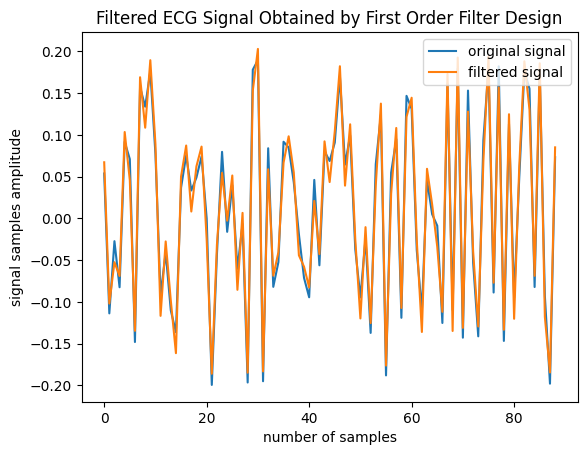

In [6]:
w=np.array([0 , 0])                  
a=np.zeros(len(t)-1); 
V=np.array([v[1:90], v[0:89]]) 
T=t[1:90]
num_iter = 10000
alpha = 0.001

for i in range(num_iter):
    k = np.random.randint(1,n)
    w = w+2*alpha*e[k]*V[:,k]
    a = np.transpose(w).dot(V)
    e = T-a

plt.figure(2)
plt.plot(S[1:90])
plt.plot(e)
plt.legend(('original signal','filtered signal'),loc='upper right')
plt.title('Filtered ECG Signal Obtained by First Order Filter Design')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Second Order Filter Design: ADALINE Design based on Iterative Solution 
- The optimal solution is obtained by minimizing least mean square (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$.

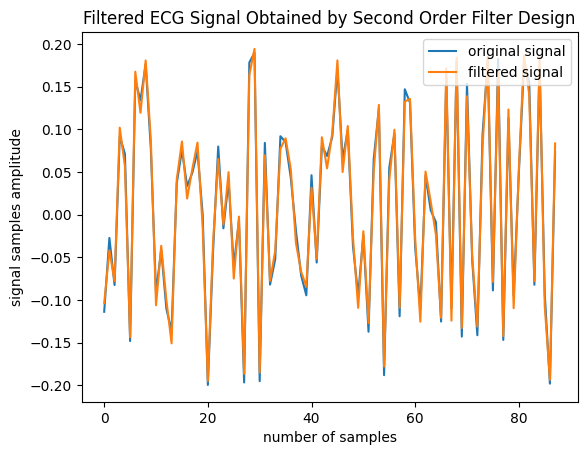

In [7]:
w=np.array([0, 0, 0])                  
a=np.zeros(len(t)-1); 
V=np.array([v[2:90], v[1:89], v[0:88]]) 
T=t[2:90]
num_iter = 10000
alpha = 0.001

for i in range(num_iter):
    k = np.random.randint(1,n-1)
    w = w+2*alpha*e[k]*V[:,k]
    a = np.transpose(w).dot(V)
    e = T-a

plt.figure(2)
plt.plot(S[2:90])
plt.plot(e)
plt.legend(('original signal','filtered signal'),loc='upper right')
plt.title('Filtered ECG Signal Obtained by Second Order Filter Design')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Filter Design: ADALINE Design based using KERAS
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiltered signal $T(k)$ considered as target signal and the output of ADALINE network. 
- KERAS allow to define optimization algorithms and paremetters


In [8]:
V=np.array([v[1:90], v[0:89]]) 
T=t[1:90]
X = V.T 
Y = T  

model = models.Sequential()
model.add(layers.Dense(1, activation='linear', input_shape=(2,), kernel_initializer='zeros', bias_initializer='zeros'))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(X, Y, batch_size=4, epochs=100, verbose=0)

 # Simulate ADALINE
 - obtain the synaptic weights from network model via **model.get_weights()** and propagate the input signal to the ADALINE output **$a(t)$** using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ or  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$ corresponding to first or second order ADALINE flter. 

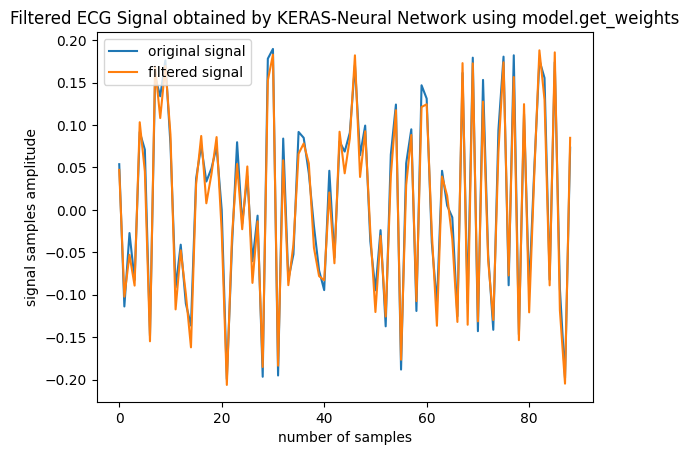

In [9]:
weights = model.get_weights() 
weights_0 = np.array(weights[0]) 
weights_1 = np.array(weights[1]) 

a = np.dot(X, weights_0) + weights_1 
e = (T - a.T)

plt.plot(S[1:90])
plt.plot(e.T)
plt.legend(('original signal','filtered signal'),loc='upper left')
plt.title('Filtered ECG Signal obtained by KERAS-Neural Network using model.get_weights')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Simulate ADALINE
 - propagate the input signal using  KERAS command **model.predict(input_NN)** in order to obtain the ADALINE output **$a(t)$**

3/3 [==============================] - 0s 1ms/step


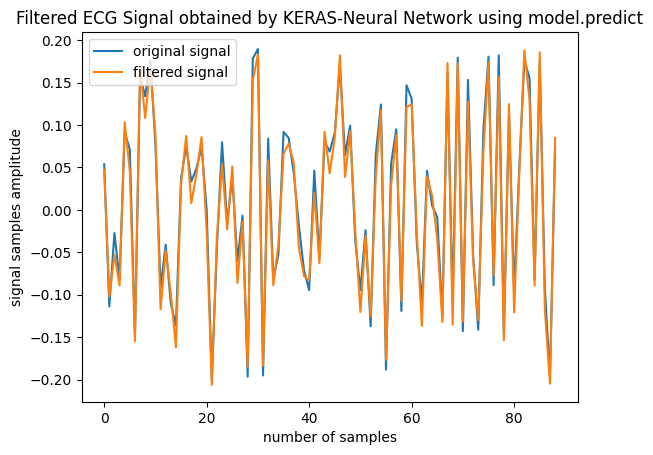

In [10]:
a_test = model.predict(X) 
T_test = np.array([Y]).T 
e = T_test - a_test

plt.plot(S[1:90])
plt.plot(e)
plt.legend(('original signal','filtered signal'),loc='upper left')
plt.title('Filtered ECG Signal obtained by KERAS-Neural Network using model.predict')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Conclusion

Les différences entre les différents types de filtres ADALINE sont les suivantes :

Avec un filtre ADALINE itérative de premier ordre, les poids synaptiques sont mis à jour à chaque itération en utilisant l'algorithme LMS (least mean square). Cette approche nécessite un certain nombre d'itérations pour converger vers la solution optimale.

Le filtre ADALINE itérative de second ordre est similaire au précédent mais donne de meilleurs résultats que le filtre de premier ordre.

Avec le filtre ADALINE avec Keras et model.get_weights(), les poids synaptiques sont obtenus à partir du modèle via la méthode model.get_weights(), puis utilisés pour propager le signal d'entrée à la sortie d'ADALINE à l'aide de l'expression mathématique correspondante. Cette approche est plus rapide et plus simple que les approches itératives, mais elle nécessite une connaissance préalable des poids optimaux pour le réseau. Elle semble être aussi efficace que le filtre de premier ordre.

Avec le filtre ADALINE avec Keras et model.predict(), les poids synaptiques sont déterminés par l'algorithme d'apprentissage en utilisant les données d'entrée et de sortie. Cette approche est plus flexible que les autres approches car elle permet l'apprentissage automatique des poids synaptiques à partir des données d'entrée et de sortie. Elle semble être aussi efficace que le filtre de premier ordre et la méthode avec model.get_weights().